In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install q tensorflow==2.1
!pip install q keras==2.3.1

# v1
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# v3
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.metrics import *
# v4

ACCURACY_LIST = []
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.models import Model

# v5
!pip install efficientnet
from efficientnet.keras import EfficientNetB4
from keras import backend as K

# v6
# Get reproducible results
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [ ]:
metadata = pd.read_csv('/content/drive/My Drive/kaggle/Chest_xray_Corona_Metadata.csv')
summary = pd.read_csv('/content/drive/My Drive/kaggle/Chest_xray_Corona_dataset_Summary.csv')

In [ ]:
metadata.sample(10)

Unnamed: 0  ... Label_1_Virus_category
4519        4519  ...               bacteria
3147        3147  ...               bacteria
3037        3037  ...               bacteria
712          712  ...                    NaN
5411        5434  ...                    NaN
2126        2126  ...               bacteria
5065        5065  ...                  Virus
2639        2639  ...               bacteria
3821        3821  ...               bacteria
416          416  ...                    NaN

[10 rows x 6 columns]

In [ ]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == metadata.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


Unnamed: 0  ... Label_1_Virus_category
5675        5698  ...               bacteria
5807        5830  ...                  Virus
5455        5478  ...                    NaN
5609        5632  ...               bacteria
5798        5821  ...                  Virus
5597        5620  ...               bacteria
5895        5918  ...                  Virus
5671        5694  ...               bacteria
5590        5613  ...               bacteria
5869        5892  ...                  Virus

[10 rows x 6 columns]

### Exploratory Data Analysis
- Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [ ]:
# Null value calculation
print(f"Count of null values in train :\n{train_data.isnull().sum()}\n\n")
print(f"Count of null values in test :\n{test_data.isnull().sum()}")

Count of null values in train :
Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5217
Label_1_Virus_category    1342
dtype: int64


Count of null values in test :
Unnamed: 0                  0
X_ray_image_name            0
Label                       0
Dataset_type                0
Label_2_Virus_category    624
Label_1_Virus_category    234
dtype: int64


In [ ]:
# Substitute null values with string unknown
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')

train_fill.sample(10)

Unnamed: 0  ... Label_1_Virus_category
4724        4724  ...                  Virus
991          991  ...                unknown
1601        1601  ...               bacteria
428          428  ...                unknown
2080        2080  ...               bacteria
4768        4768  ...               bacteria
4352        4352  ...               bacteria
2690        2690  ...               bacteria
2914        2914  ...               bacteria
3971        3971  ...               bacteria

[10 rows x 6 columns]

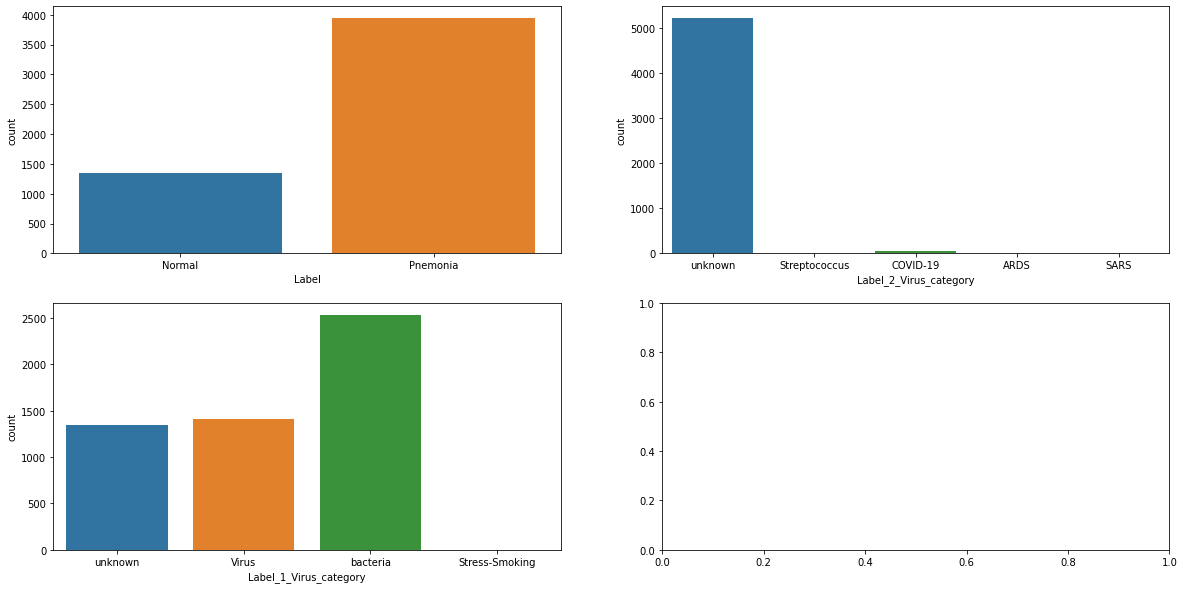

In [ ]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

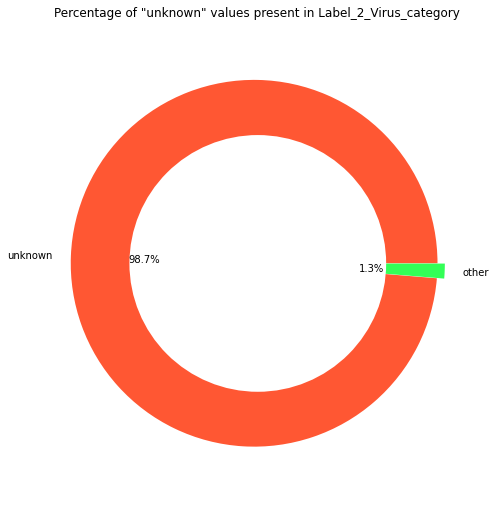

In [ ]:
# Pie chart representation of Label_2_Virus_category values

colors = ['#ff5733', '#33ff57']
explode = [0.02, 0.02]

values = ['unknown', 'other']
percentages = [100 * (train_fill[train_fill[targets[1]] == 'unknown'].shape[0]) / train_fill.shape[0],
              100 * (train_fill[train_fill[targets[1]] != 'unknown'].shape[0]) / train_fill.shape[0]]

fig1, ax1 = plt.subplots(figsize=(7, 7))

plt.pie(percentages, colors=colors, labels=values,
        autopct='%1.1f%%', startangle=0, explode=explode)
fig = plt.gcf()
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.title('Percentage of "unknown" values present in Label_2_Virus_category')
plt.show()

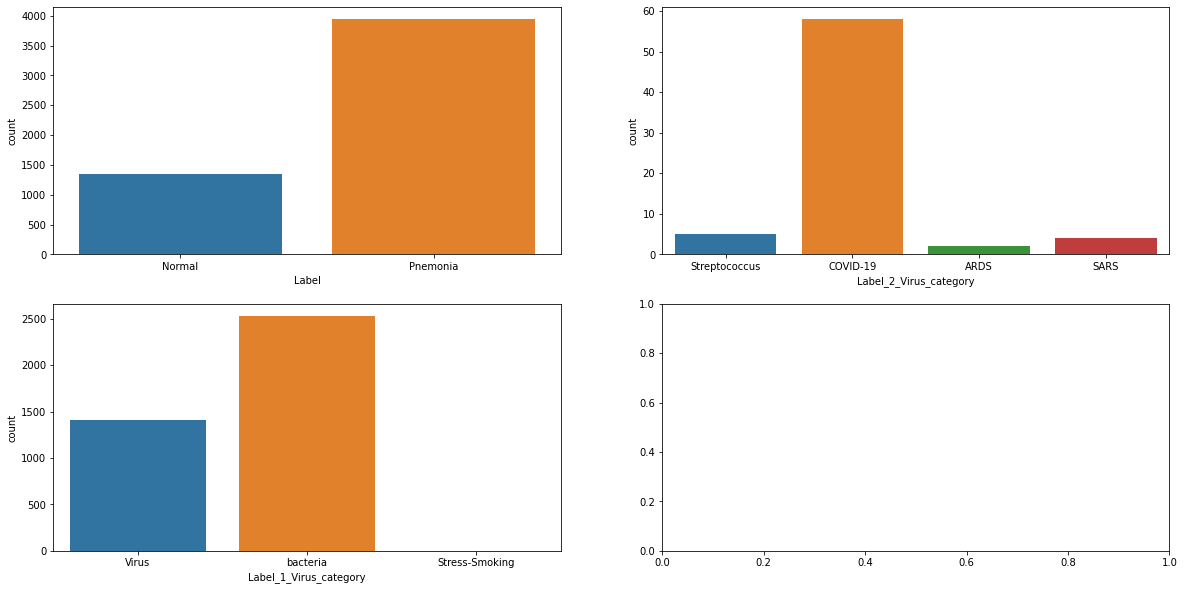

In [ ]:
# Count plot for 3 target variables without filling unknown variable
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_data, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_data, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_data, ax=ax[1, 0])
plt.show()

In [ ]:
print(f"Label = Normal Cases : {train_data[train_data['Label'] == 'Normal'].shape[0]}")
print(f"""Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Pnemonia')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")
print(f"""Label = Normal + Label_2_Virus_category = COVID-19 cases : {train_data[(train_data['Label'] == 'Normal')
      & (train_data['Label_2_Virus_category'] == 'COVID-19')].shape[0]}""")

Label = Normal Cases : 1342
Label = Pnemonia + Label_2_Virus_category = COVID-19 cases : 58
Label = Normal + Label_2_Virus_category = COVID-19 cases : 0


In [ ]:
TEST_FOLDER = '/content/drive/My Drive/kaggle/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
TRAIN_FOLDER = '/content/drive/My Drive/kaggle/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(TEST_FOLDER) == True
assert os.path.isdir(TRAIN_FOLDER) == True

In [ ]:
sample_train_images = list(os.walk(TRAIN_FOLDER))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_train_images))

sample_test_images = list(os.walk(TEST_FOLDER))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(TEST_FOLDER, x), sample_test_images))

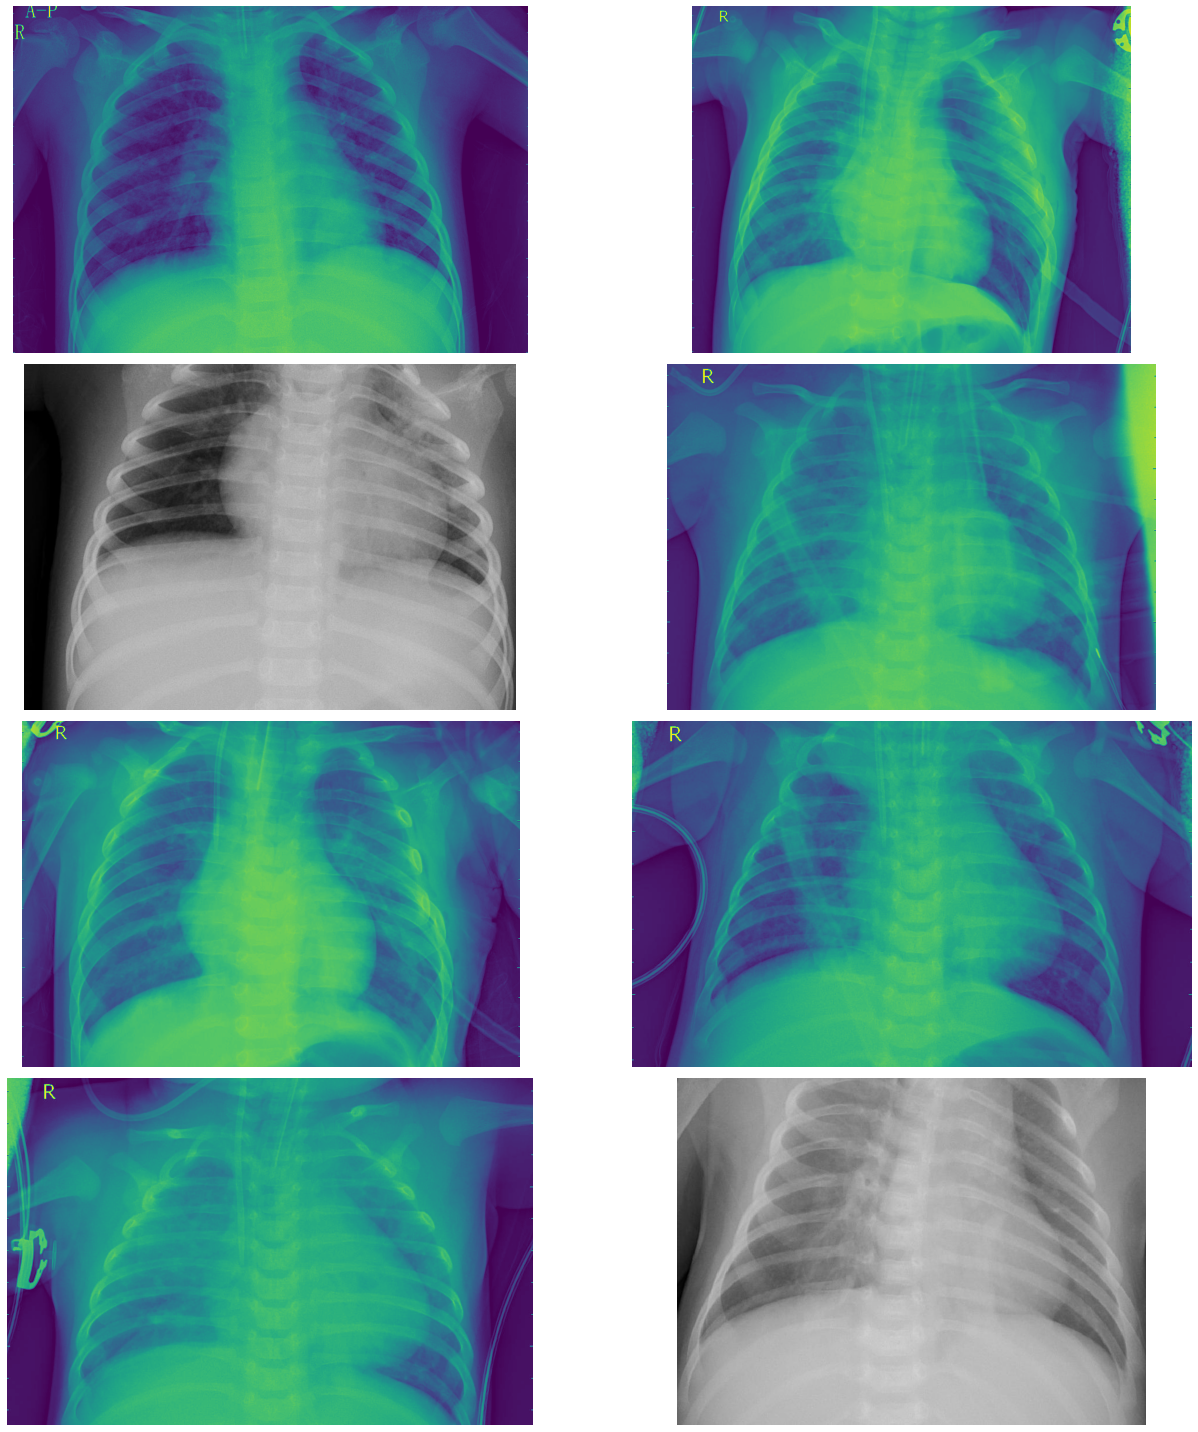

In [ ]:
# Plot sample training images
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()

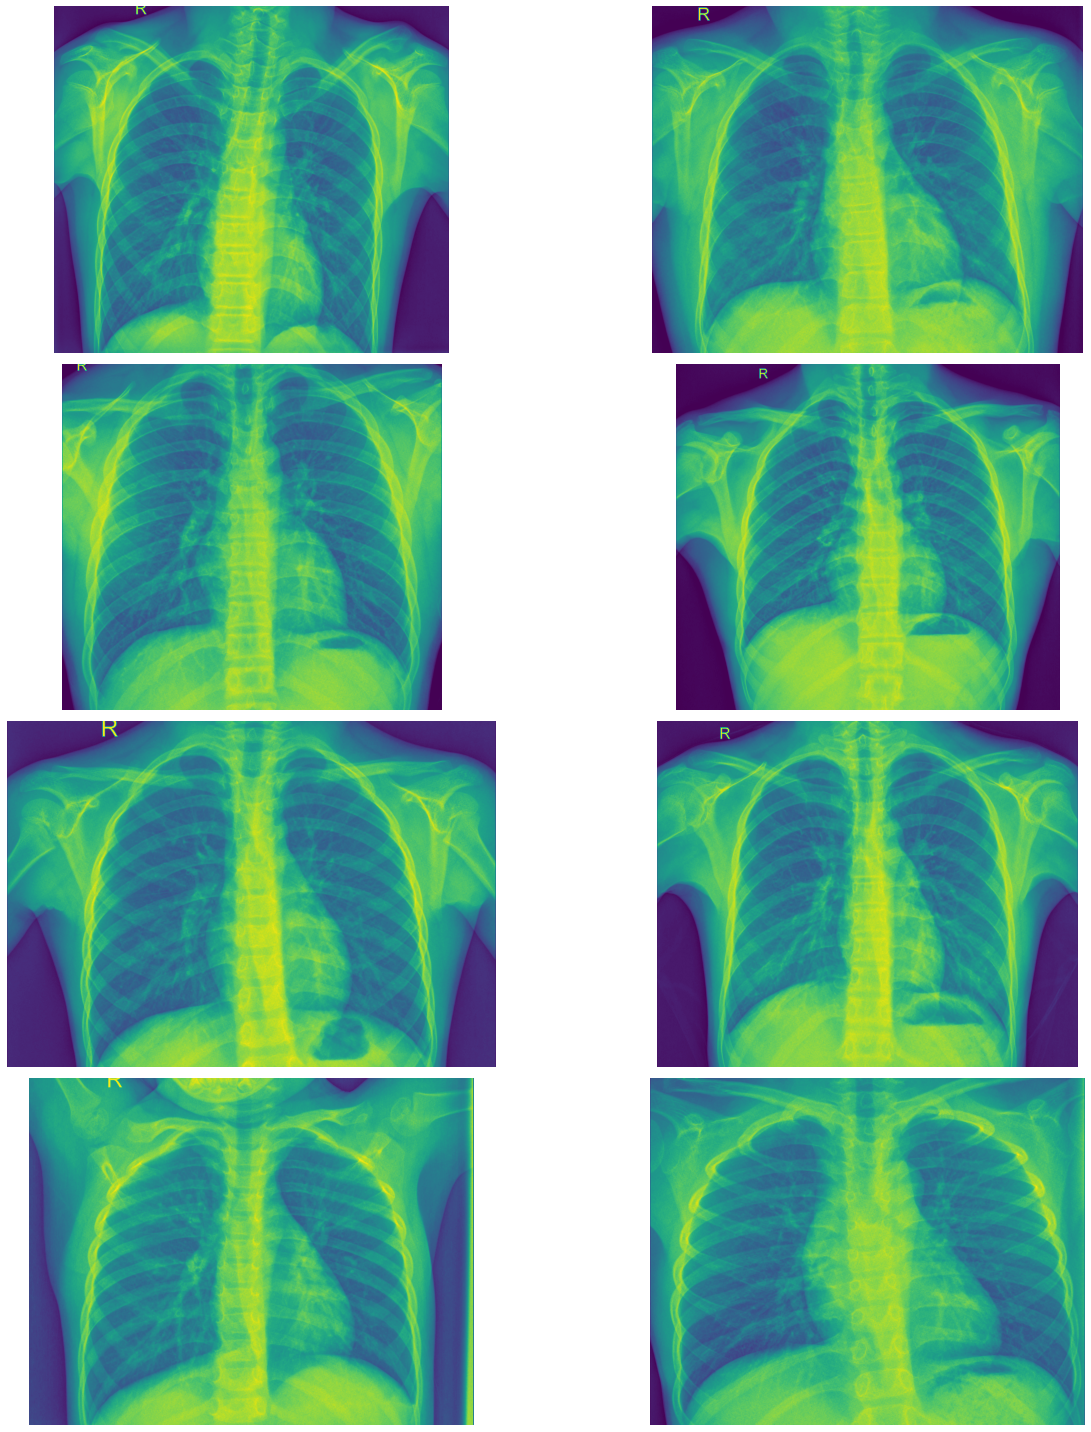

In [ ]:
# Plot sample testing images
plt.figure(figsize=(20, 20))

for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4, 2, iterator+1)
    plt.axis('off')
    plt.imshow(image)


plt.tight_layout()

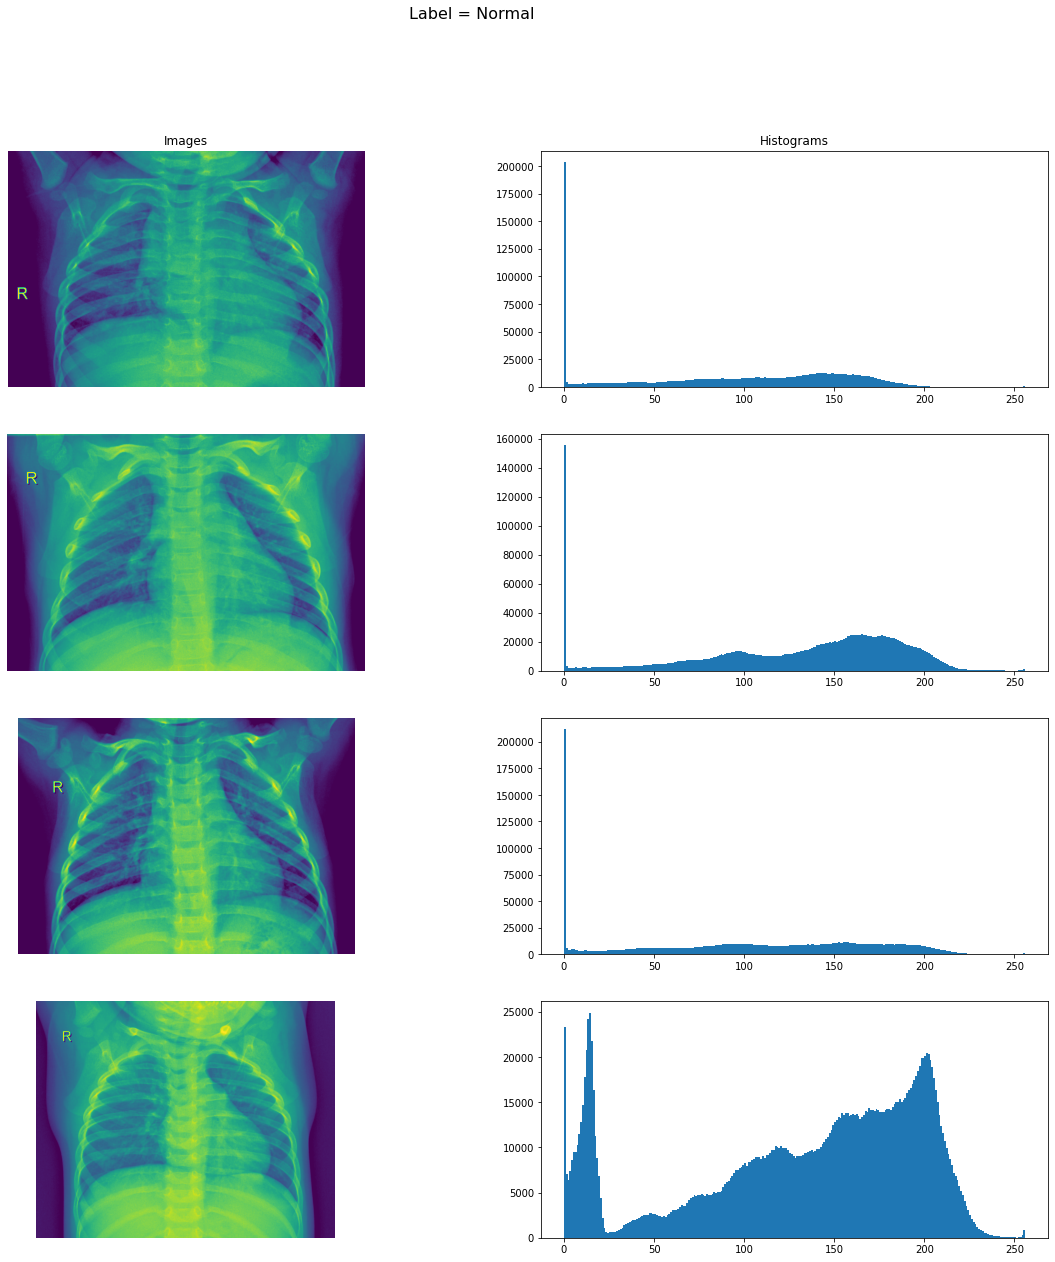

In [ ]:
# Plot b/w image histograms of Label type "Normal" patients 
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

other_type_file_paths = train_data[train_data['Label'] == 'Normal']['X_ray_image_name'].values
sample_other_file_paths = other_type_file_paths[:4]
sample_other_file_paths = list(map(lambda x: os.path.join(TRAIN_FOLDER, x), sample_other_file_paths))

for row, file_path in enumerate(sample_other_file_paths):
    image = plt.imread(file_path)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = Normal', size=16)
plt.show()

In [ ]:
# Generate the final train data from original train data with conditions refered from EDA inference
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 7)


Unnamed: 0  ...    target
649          649  ...  negative
663          663  ...  negative
297          297  ...  negative
33            33  ...  negative
1232        1232  ...  negative
1322        1322  ...  negative
1124        1124  ...  negative
1268        1268  ...  negative
90            90  ...  negative
19            19  ...  negative

[10 rows x 7 columns]

In [ ]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=TEST_FOLDER,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None
)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


In [ ]:
def scheduler(epoch):
    if epoch < 5:
        return 0.0001
    else:
        print(f"Learning rate reduced to {0.0001 * np.exp(0.5 * (5 - epoch))}")
        return 0.0001 * np.exp(0.5 * (5 - epoch))
    
custom_callback = LearningRateScheduler(scheduler)

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)

In [ ]:
history = model.fit_generator(train_generator,
                   validation_data=validation_generator,
                   epochs=20,
                   callbacks=[custom_callback])

Epoch 1/20
125/125 [==============================] - 1061s 8s/step - loss: 0.2392 - tp: 0.0000e+00 - fp: 12.0000 - tn: 953.0000 - fn: 35.0000 - accuracy: 0.9530 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5498 - val_loss: 0.4653 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6642
Epoch 2/20
125/125 [==============================] - 44s 351ms/step - loss: 0.1960 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 965.0000 - fn: 35.0000 - accuracy: 0.9650 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5228 - val_loss: 0.0146 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 377.0000 - val_fn: 23.0000 - val_accuracy: 0.9425 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4746
Epoch 3/20
125/125 [==============================] - 44s 348ms/step - loss: 0.1917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 965.0000 - fn: 35.0000 - accuracy: 0.9650 - pr

In [ ]:
model.save('covid19_xray_base_cnn_model.h5')
ACCURACY_LIST.append(['Base CNN Model', history])

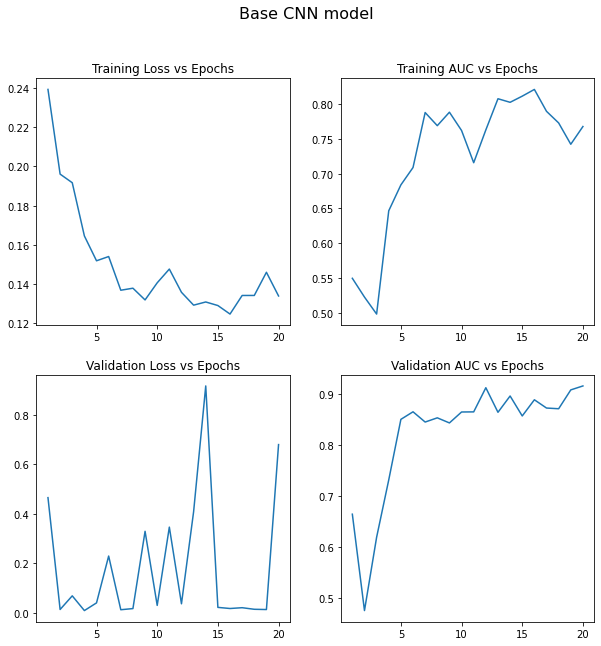

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Base CNN model', size=16)
plt.show()

In [ ]:
balanced_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]

balanced_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in balanced_data['Label']]

balanced_data_subset_normal = balanced_data[balanced_data['target'] == 'negative']
balanced_data_subset_covid = balanced_data[balanced_data['target'] == 'positive']
balanced_data_frac_normal = balanced_data_subset_normal.sample(frac=(1/5))

balanced_data_concat = pd.concat([balanced_data_frac_normal, balanced_data_subset_covid], axis=0)
balanced_data_concat = shuffle(balanced_data_concat, random_state=0)
balanced_data_train = balanced_data_concat[:240]
balanced_data_validation = balanced_data_concat[240:]

print(f"Balanced train data shape {balanced_data_train.shape}")
print(f"Balanced validation data shape {balanced_data_validation.shape}")

Balanced train data shape (240, 7)
Balanced validation data shape (86, 7)


In [ ]:
balanced_train_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_train,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

balanced_validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=balanced_data_validation,
    directory=TRAIN_FOLDER,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 240 validated image filenames belonging to 2 classes.
Found 86 validated image filenames belonging to 2 classes.


In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

balanced_model = Sequential([
    Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
balanced_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)             

In [ ]:
balanced_model.compile(optimizer=Adam(), loss=binary_crossentropy,
             metrics=METRICS)
balanced_history = balanced_model.fit_generator(balanced_train_generator,
                                               epochs=30,
                                               validation_data=balanced_validation_generator,
                                               callbacks=[custom_callback])

Epoch 1/30
4/4 [==============================] - 11s 3s/step - loss: 0.6379 - tp: 3.0000 - fp: 29.0000 - tn: 174.0000 - fn: 34.0000 - accuracy: 0.7375 - precision: 0.0938 - recall: 0.0811 - auc: 0.4775 - val_loss: 0.6197 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 21.0000 - val_accuracy: 0.7558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5341
Epoch 2/30
4/4 [==============================] - 10s 2s/step - loss: 0.5726 - tp: 1.0000 - fp: 4.0000 - tn: 199.0000 - fn: 36.0000 - accuracy: 0.8333 - precision: 0.2000 - recall: 0.0270 - auc: 0.4657 - val_loss: 0.5201 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 21.0000 - val_accuracy: 0.7558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6575
Epoch 3/30
4/4 [==============================] - 10s 2s/step - loss: 0.5036 - tp: 0.0000e+00 - fp: 1.0000 - tn: 202.0000 - fn: 37.0000 - accuracy: 0.8417 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5087

In [ ]:
balanced_model.save('covid19_xray_base_cnn_model_balanced.h5')
ACCURACY_LIST.append(['Balanced Base Model', balanced_history])

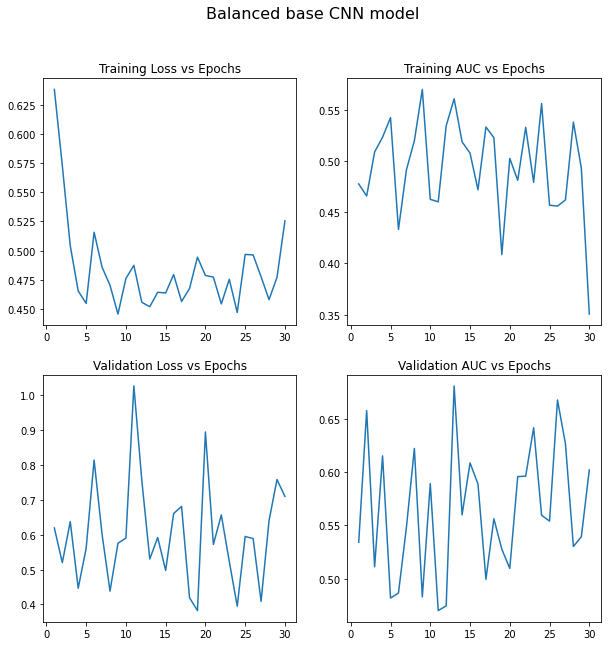

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 31), y=balanced_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('Balanced base CNN model', size=16)
plt.show()

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

def output_custom_model(prebuilt_model):
    print(f"Processing {prebuilt_model}")
    prebuilt = prebuilt_model(include_top=False,
                            input_shape=(224, 224, 3),
                            weights='imagenet')
    output = prebuilt.output
    output = GlobalMaxPooling2D()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(1, activation='sigmoid')(output)

    model = Model(inputs=prebuilt.input, outputs=output)
    model.compile(optimizer='sgd', loss=binary_crossentropy,
              metrics=METRICS)
    return model

In [ ]:
resnet_custom_model = output_custom_model(ResNet50)
resnet_history = resnet_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

Processing <function keras_modules_injection.<locals>.wrapper at 0x7f87415c8e18>
94658560/94653016 [==============================] - 8s 0us/step
Epoch 1/20
125/125 [==============================] - 66s 530ms/step - loss: 0.3988 - tp: 1.0000 - fp: 31.0000 - tn: 934.0000 - fn: 34.0000 - accuracy: 0.9350 - precision: 0.0312 - recall: 0.0286 - auc: 0.5685 - val_loss: 1.9969 - val_tp: 23.0000 - val_fp: 377.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0575 - val_precision: 0.0575 - val_recall: 1.0000 - val_auc: 0.3526
Epoch 2/20
125/125 [==============================] - 53s 427ms/step - loss: 0.3181 - tp: 3.0000 - fp: 24.0000 - tn: 941.0000 - fn: 32.0000 - accuracy: 0.9440 - precision: 0.1111 - recall: 0.0857 - auc: 0.6583 - val_loss: 2.9823 - val_tp: 23.0000 - val_fp: 371.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0725 - val_precision: 0.0584 - val_recall: 1.0000 - val_auc: 0.5694
Epoch 3/20
125/125 [==============================] - 53s 425ms/step -

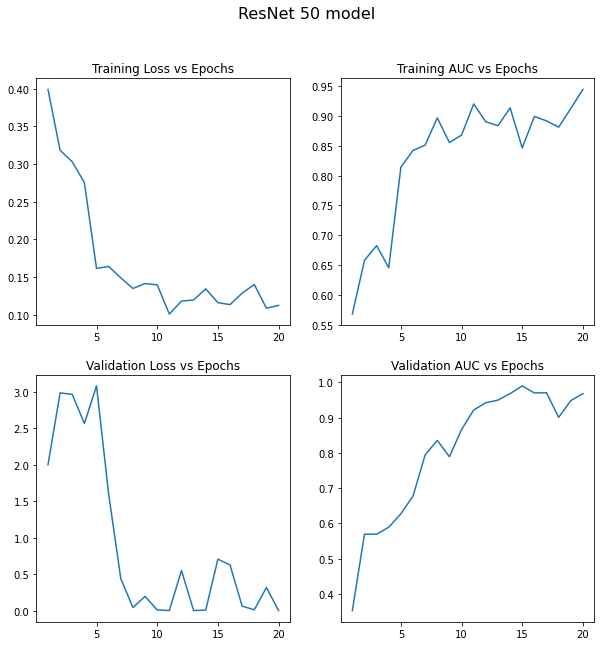

In [ ]:
resnet_custom_model.save('covid19_xray_resnet_50.h5')
ACCURACY_LIST.append(['ResNet 50', resnet_history])

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=resnet_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('ResNet 50 model', size=16)
plt.show()

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

efficient_net_custom_model = output_custom_model(EfficientNetB4)
efficient_net_history = efficient_net_custom_model.fit_generator(train_generator,
                                 epochs=20,
                                 validation_data=validation_generator,
                                 callbacks=[custom_callback])

Processing <function EfficientNetB4 at 0x7f873f359400>
71892992/71892840 [==============================] - 6s 0us/step
Epoch 1/20
125/125 [==============================] - 98s 786ms/step - loss: 0.3895 - tp: 5.0000 - fp: 81.0000 - tn: 884.0000 - fn: 30.0000 - accuracy: 0.8890 - precision: 0.0581 - recall: 0.1429 - auc: 0.5217 - val_loss: 0.0822 - val_tp: 0.0000e+00 - val_fp: 10.0000 - val_tn: 367.0000 - val_fn: 23.0000 - val_accuracy: 0.9175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3438
Epoch 2/20
125/125 [==============================] - 65s 517ms/step - loss: 0.2717 - tp: 1.0000 - fp: 18.0000 - tn: 947.0000 - fn: 34.0000 - accuracy: 0.9480 - precision: 0.0526 - recall: 0.0286 - auc: 0.4381 - val_loss: 0.4624 - val_tp: 0.0000e+00 - val_fp: 14.0000 - val_tn: 363.0000 - val_fn: 23.0000 - val_accuracy: 0.9075 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5143
Epoch 3/20
125/125 [==============================] - 64s 513ms/step - loss: 0.221

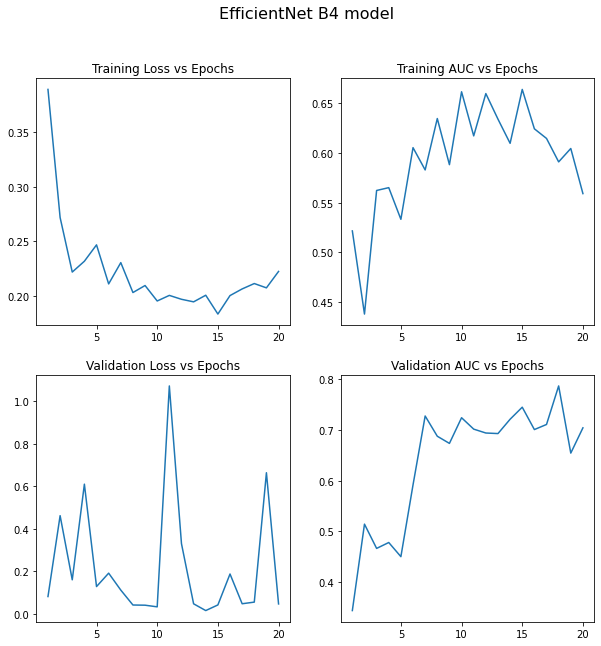

In [ ]:
efficient_net_custom_model.save('covid19_xray_efficient_net_B4.h5')
ACCURACY_LIST.append(['EfficientNet B4', efficient_net_history])
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('auc'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 21), y=efficient_net_history.history.get('val_auc'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training AUC vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation AUC vs Epochs')
fig.suptitle('EfficientNet B4 model', size=16)
plt.show()

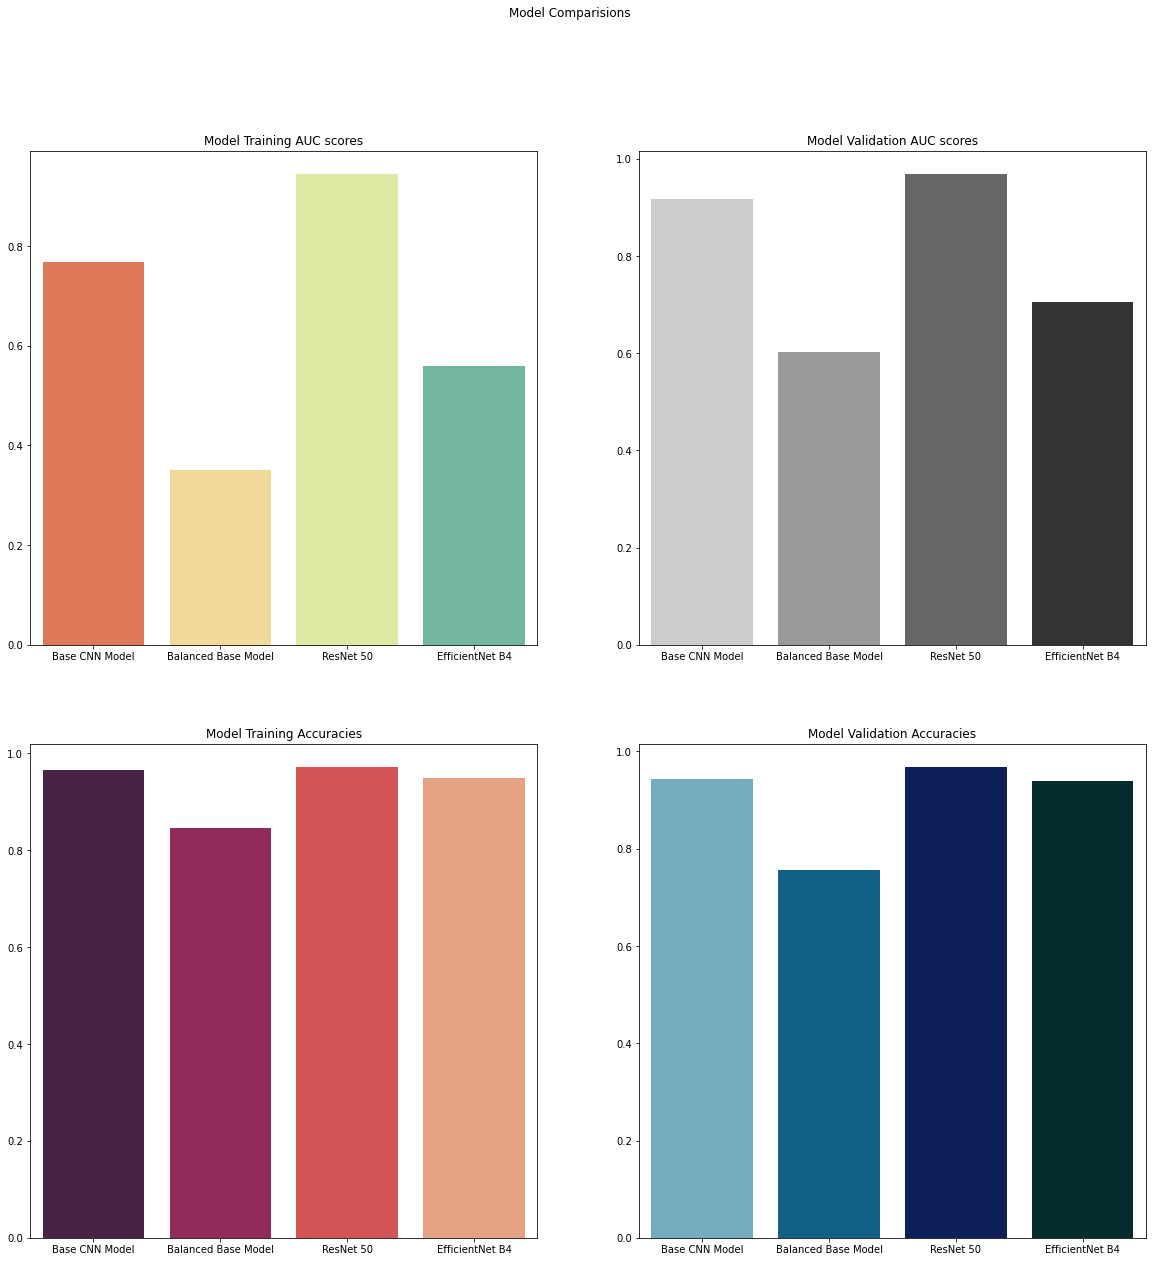

In [ ]:
ACCURACY_LIST = np.array(ACCURACY_LIST)
model_names = ACCURACY_LIST[:, 0]
histories = ACCURACY_LIST[:, 1]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('accuracy')[-1], histories)), ax=ax[1, 0], palette='rocket')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_accuracy')[-1], histories)), ax=ax[1, 1], palette='ocean_r')
ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Accuracies')
ax[1, 1].set_title('Model Validation Accuracies')
fig.suptitle('Model Comparisions')
plt.show()

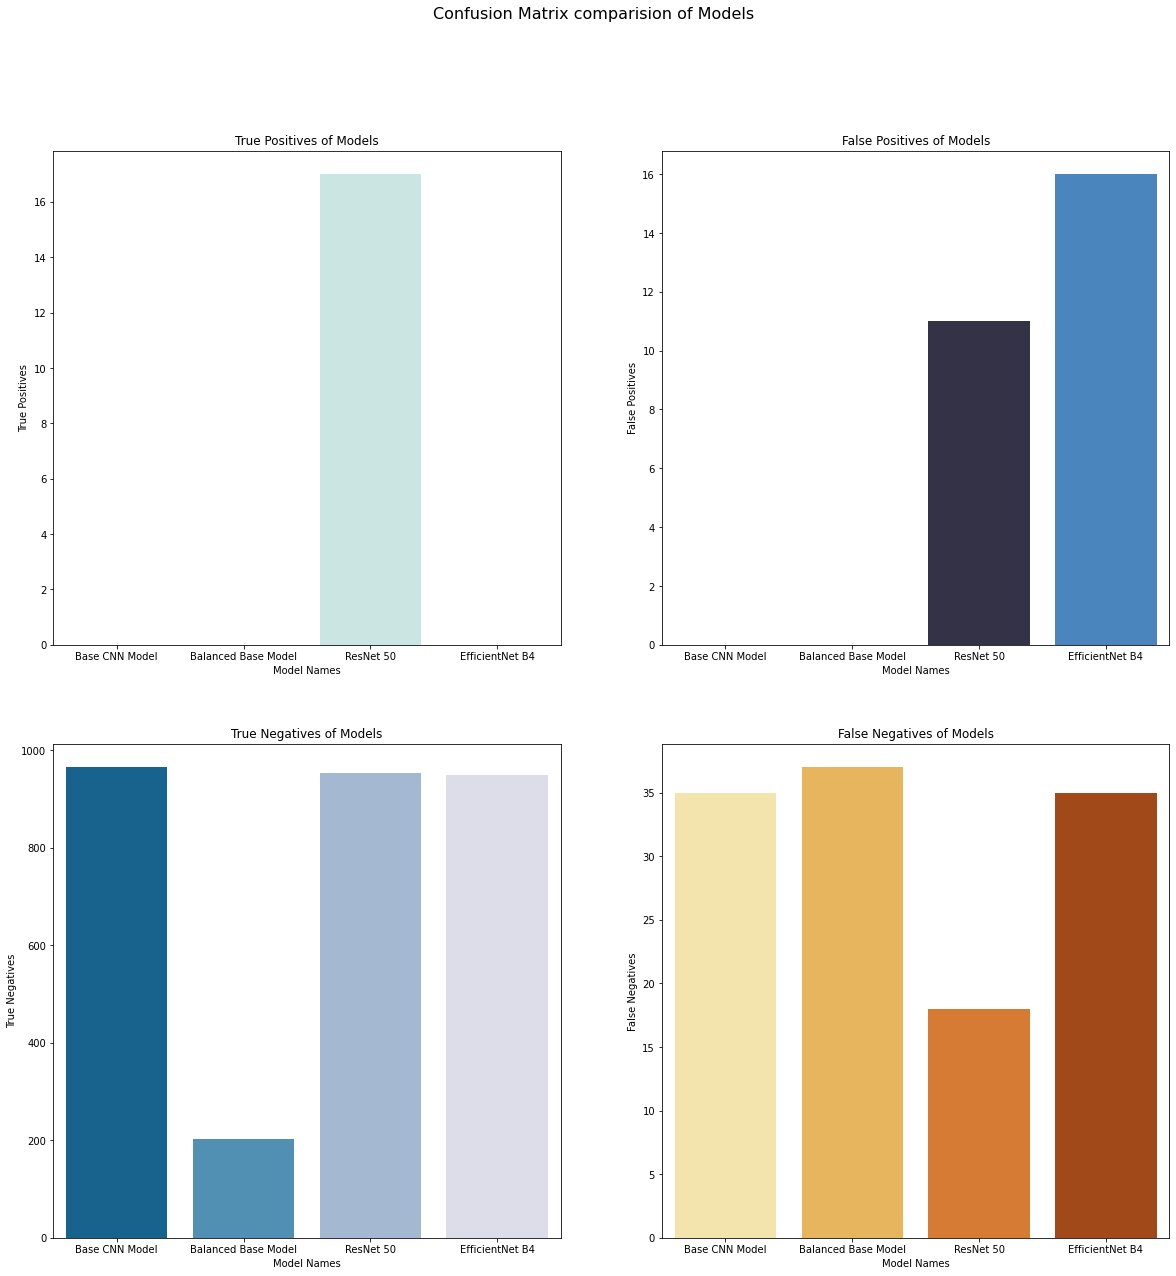

In [ ]:
metric_dataframe = pd.DataFrame({
    'Model Names': model_names,
    'True Positives': list(map(lambda x: x.history.get('tp')[-1], histories)),
    'False Positives': list(map(lambda x: x.history.get('fp')[-1], histories)),
    'True Negatives': list(map(lambda x: x.history.get('tn')[-1], histories)),
    'False Negatives': list(map(lambda x: x.history.get('fn')[-1], histories))
})
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='Model Names', y='True Positives', data=metric_dataframe, ax=ax[0, 0], palette='BrBG')
sns.barplot(x='Model Names', y='False Positives', data=metric_dataframe, ax=ax[0, 1], palette='icefire_r')
sns.barplot(x='Model Names', y='True Negatives', data=metric_dataframe, ax=ax[1, 0], palette='PuBu_r')
sns.barplot(x='Model Names', y='False Negatives', data=metric_dataframe, ax=ax[1, 1], palette='YlOrBr')
ax[0, 0].set_title('True Positives of Models')
ax[0, 1].set_title('False Positives of Models')
ax[1, 0].set_title('True Negatives of Models')
ax[1, 1].set_title('False Negatives of Models')
fig.suptitle('Confusion Matrix comparision of Models', size=16)
plt.show()